In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 750ms/step - loss: 0.0142
Average validation loss: 0.6560487747192383
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 769ms/step - loss: 0.0142 - val_loss: 0.6560
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 747ms/step - loss: 0.0103 - val_loss: 0.6560
Average validation loss: 0.41880327463150024
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 766ms/step - loss: 0.0103 - val_loss: 0.5374
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 768ms/step - loss: 0.0078 - val_loss: 0.5374
Average validation loss: 0.26052096486091614
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 790ms/step - loss: 0.0078 - val_loss: 0.4451
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 778ms/step - loss: 3.9501e-06
Average validation loss: 0.11392714828252792
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 790ms/step - loss: 3.9501e-06 - val_loss: 0.1139
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 779ms/step - loss: 3.7308e-06 - val_loss: 0.1139
Average validation loss: 0.06579598598182201
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 790ms/step - loss: 3.7308e-06 - val_loss: 0.0899
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 776ms/step - loss: 3.5822e-06 - val_loss: 0.0899
Average validation loss: 0.12004204094409943
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 790ms/step - loss: 3.5822e-06 - val_loss: 0.0999
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 776ms/step - loss: 3.5333e-06 - val_loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 814ms/step - loss: 1.2844e-06
Average validation loss: 0.06833131176729997
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 823ms/step - loss: 1.2844e-06 - val_loss: 0.0683
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 804ms/step - loss: 1.2519e-06 - val_loss: 0.0683
Average validation loss: 0.042852334678173065
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 815ms/step - loss: 1.2519e-06 - val_loss: 0.0556
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 836ms/step - loss: 1.2762e-06 - val_loss: 0.0556
Average validation loss: 0.031084479143222172
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 847ms/step - loss: 1.2762e-06 - val_loss: 0.0474
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\w

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step - loss: 8.0715e-07
Average validation loss: 0.013504350557923317
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 786ms/step - loss: 8.0715e-07 - val_loss: 0.0135
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 772ms/step - loss: 7.9244e-07 - val_loss: 0.0135
Average validation loss: 0.009229638846591115
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 784ms/step - loss: 7.9244e-07 - val_loss: 0.0114
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 777ms/step - loss: 7.1615e-07 - val_loss: 0.0114
Average validation loss: 0.009700702037662268
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 7.1615e-07 - val_loss: 0.0108
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 771ms/step - loss: 7.15

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 847ms/step - loss: 7.5613e-07
Average validation loss: 0.006650152802467346
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 857ms/step - loss: 7.5613e-07 - val_loss: 0.0067
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 784ms/step - loss: 6.4822e-07 - val_loss: 0.0067
Average validation loss: 0.010728869773447513
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 794ms/step - loss: 6.4822e-07 - val_loss: 0.0087
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 777ms/step - loss: 5.7425e-07 - val_loss: 0.0087
Average validation loss: 0.01576439095661044
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 787ms/step - loss: 5.7425e-07 - val_loss: 0.0110
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 804ms/step - loss: 5.3179e-07 - val_loss: 0.0110
Average validation loss: 0.009569708351045847
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 814ms/step - loss: 5.3179e-07 - val_loss: 0.0107
Epoch 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - loss: 6.6913e-07
Average validation loss: 0.010096191777847707
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 796ms/step - loss: 6.6913e-07 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 775ms/step - loss: 5.4686e-07 - val_loss: 0.0101
Average validation loss: 0.012141952795597414
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 784ms/step - loss: 5.4686e-07 - val_loss: 0.0111
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 775ms/step - loss: 4.6109e-07 - val_loss: 0.0111
Average validation loss: 0.00781426850395898
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 785ms/step - loss: 4.6109e-07 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 779ms/step - loss: 4.136

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 765ms/step - loss: 9.3323e-07
Average validation loss: 0.06947850035503507
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - loss: 9.3323e-07 - val_loss: 0.0695
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 778ms/step - loss: 8.0065e-07 - val_loss: 0.0695
Average validation loss: 0.038756546936929225
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 789ms/step - loss: 8.0065e-07 - val_loss: 0.0541
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 762ms/step - loss: 7.1124e-07 - val_loss: 0.0541
Average validation loss: 0.032407736964523794
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 773ms/step - loss: 7.1124e-07 - val_loss: 0.0469
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\w

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 772ms/step - loss: 7.1075e-07
Average validation loss: 0.026566795577916007
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 784ms/step - loss: 7.1075e-07 - val_loss: 0.0266
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 782ms/step - loss: 5.3029e-07 - val_loss: 0.0266
Average validation loss: 0.016782472531000774
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 793ms/step - loss: 5.3029e-07 - val_loss: 0.0217
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 782ms/step - loss: 4.4171e-07 - val_loss: 0.0217
Average validation loss: 0.01807715673930943
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 794ms/step - loss: 4.4171e-07 - val_loss: 0.0205
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 785ms/step - loss: 4.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 890ms/step - loss: 4.4455e-07
Average validation loss: 0.01773490766728563
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 901ms/step - loss: 4.4455e-07 - val_loss: 0.0177
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 894ms/step - loss: 3.7883e-07 - val_loss: 0.0177
Average validation loss: 0.04681733889239175
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 905ms/step - loss: 3.7883e-07 - val_loss: 0.0323
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 773ms/step - loss: 3.2444e-07 - val_loss: 0.0323
Average validation loss: 0.02057346425551389
56/56 ━━━━━━━━━━━━━━━━━━━━ 145s 784ms/step - loss: 3.2444e-07 - val_loss: 0.0284
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 191s 829ms/step - loss: 2.8871e-07 - val_loss: 0.0284
Average validation loss: 0.017848111289952482
56/56 ━━━━━━━━━━━━━━━━━━━━ 192s 841ms/step - loss: 2.8871e-07 - val_loss: 0.0257
Ep

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 781ms/step - loss: 3.7220e-07
Average validation loss: 0.03431785455904901
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 792ms/step - loss: 3.7220e-07 - val_loss: 0.0343
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 790ms/step - loss: 3.0099e-07 - val_loss: 0.0343
Average validation loss: 0.020099682791624218
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 802ms/step - loss: 3.0099e-07 - val_loss: 0.0272
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 785ms/step - loss: 5.7756e-07 - val_loss: 0.0272
Average validation loss: 0.049439427559264004
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 796ms/step - loss: 5.7756e-07 - val_loss: 0.0346
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 779ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 774ms/step - loss: 5.0800e-07
Average validation loss: 0.015245044629813896
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 784ms/step - loss: 5.0800e-07 - val_loss: 0.0152
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 777ms/step - loss: 3.6694e-07 - val_loss: 0.0152
Average validation loss: 0.035424593939549394
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 788ms/step - loss: 3.6694e-07 - val_loss: 0.0253
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 773ms/step - loss: 2.9854e-07 - val_loss: 0.0253
Average validation loss: 0.020061393139056034
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 783ms/step - loss: 2.9854e-07 - val_loss: 0.0236
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 225s 773ms/step - loss: 2.5375e-07 - val_loss: 0.0236
Average validation loss: 0.019102404333858028
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 784ms/step - loss: 2.5375e-07 - val_loss: 0.0225

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 776ms/step - loss: 2.1914e-07
Average validation loss: 0.05001715733669698
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 787ms/step - loss: 2.1914e-07 - val_loss: 0.0500
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 782ms/step - loss: 1.6232e-07 - val_loss: 0.0500
Average validation loss: 0.02597102480940521
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 793ms/step - loss: 1.6232e-07 - val_loss: 0.0380
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 190s 794ms/step - loss: 1.4103e-07 - val_loss: 0.0380
Average validation loss: 0.05790967140346766
80/80 ━━━━━━━━━━━━━━━━━━━━ 191s 805ms/step - loss: 1.4103e-07 - val_loss: 0.0446
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 253s 777ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 801ms/step - loss: 2.7690e-06
Average validation loss: 0.02411234483588487
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 813ms/step - loss: 2.7690e-06 - val_loss: 0.0241
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 770ms/step - loss: 1.8807e-06 - val_loss: 0.0241
Average validation loss: 0.021898564261694748
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 781ms/step - loss: 1.8807e-06 - val_loss: 0.0230
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 767ms/step - loss: 1.3696e-06 - val_loss: 0.0230
Average validation loss: 0.019601313416690875
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 779ms/step - loss: 1.3696e-06 - val_loss: 0.0219
Saved model weights to 'c:\天_11157065\git\RipplesDetection\a

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 775ms/step - loss: 1.1838e-06
Average validation loss: 0.014304224487083654
120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 786ms/step - loss: 1.1838e-06 - val_loss: 0.0143
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 778ms/step - loss: 7.5699e-07 - val_loss: 0.0143
Average validation loss: 0.025541654042899608
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 789ms/step - loss: 7.5699e-07 - val_loss: 0.0199
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 781ms/step - loss: 5.9615e-07 - val_loss: 0.0199
Average validation loss: 0.024609435856109484
120/120 ━━━━━━━━━━━━━━━━━━━━ 284s 792ms/step - loss: 5.9615e-07 - val_loss: 0.0215
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 378s 781ms/step - loss: 5.0159e-07 - val_loss: 0.0215
Average validation loss: 0.0703471326874436
120/120 ━━━━━━━━━━━━━━━━━━━━ 379s 791ms/step - loss: 5.0159e-07 - v

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 772ms/step - loss: 7.9212e-07
Average validation loss: 0.04610638099246082
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 782ms/step - loss: 7.9212e-07 - val_loss: 0.0461
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 224s 774ms/step - loss: 6.4554e-07 - val_loss: 0.0461
Average validation loss: 0.017582513089210907
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 785ms/step - loss: 6.4554e-07 - val_loss: 0.0318
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 778ms/step - loss: 5.2950e-07 - val_loss: 0.0318
Average validation loss: 0.018824718194587656
144/144 ━━━━━━━━━━━━━━━━━━━━ 339s 789ms/step - loss: 5.2950e-07 - val_loss: 0.0275
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 451s 7

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 123s 769ms/step - loss: 7.2439e-07
Average validation loss: 0.02113973321929734
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - loss: 7.2439e-07 - val_loss: 0.0211
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 248s 768ms/step - loss: 5.0072e-07 - val_loss: 0.0211
Average validation loss: 0.01568676538663567
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 779ms/step - loss: 5.0072e-07 - val_loss: 0.0184
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 374s 779ms/step - loss: 3.9743e-07 - val_loss: 0.0184
Average validation loss: 0.015185669467155095
160/160 ━━━━━━━━━━━━━━━━━━━━ 376s 789ms/step - loss: 3.9743e-07 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - loss: 4.6009e-07
Average validation loss: 0.014506737827177858
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 780ms/step - loss: 4.6009e-07 - val_loss: 0.0145
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 796ms/step - loss: 3.4616e-07 - val_loss: 0.0145
Average validation loss: 0.01595254016974195
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 807ms/step - loss: 3.4616e-07 - val_loss: 0.0152
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 475s 787ms/step - loss: 2.8404e-07 - val_loss: 0.0152
Average validation loss: 0.013252012535886024
200/200 ━━━━━━━━━━━━━━━━━━━━ 477s 798ms/step - loss: 2.8404e-07 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 633s 7

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 186s 775ms/step - loss: 4.4646e-07
Average validation loss: 0.01558591052319874
240/240 ━━━━━━━━━━━━━━━━━━━━ 189s 785ms/step - loss: 4.4646e-07 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 374s 771ms/step - loss: 3.4693e-07 - val_loss: 0.0156
Average validation loss: 0.017024455678377612
240/240 ━━━━━━━━━━━━━━━━━━━━ 376s 782ms/step - loss: 3.4693e-07 - val_loss: 0.0163
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 561s 768ms/step - loss: 3.0252e-07 - val_loss: 0.0163
Average validation loss: 0.018202869860003072
240/240 ━━━━━━━━━━━━━━━━━━━━ 563s 778ms/step - loss: 3.0252e-07 - val_loss: 0.0169
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 749s 775ms/step - loss: 2.6526e-07 - val_loss: 0.0169
Average validation loss: 0.021425182994183462
240/240 ━━━━━━━━━━━━━━━━━━━━ 752s 786ms/step - loss: 2.6526e-07 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.09988366946578026, 0.04998349288478494, 0.019441522232567274, 0.014090355759253725, 0.013954968152567743, 0.012288768632182232, 0.04059160837857054, 0.040732884707006936, 0.045718149394129534, 0.03552373473590706, 0.03201854158141133, 0.03770012384653092, 0.035512908523669465, 0.04070812973425103, 0.025501120157057612, 0.021083837388247754, 0.01952328219850397, 0.020961446996998027]
std_val_losses =  [0.1033925362385251, 0.03587833858793315, 0.013505161693662558, 0.007678673893882033, 0.007153516418252118, 0.0022676874622085444, 0.030217245534201284, 0.03237447163212716, 0.04018593442629879, 0.026944659748588767, 0.023211436271695345, 0.02405347034933718, 0.0237304688085783, 0.0269520499235489, 0.010995266634279731, 0.013404653972760437, 0.006893350904364025, 0.012092460678978015]


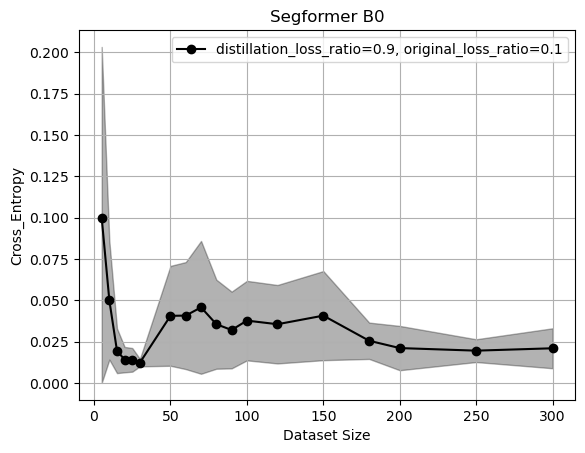

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()